# Pattern Recognition 2 - Feature Space

**Objectives**

* Compute distances between objects in feature space
* Use PCA to perform reduce the dimensionality of the problem
* Implement face recognition using [Eigenfaces](http://en.wikipedia.org/wiki/Eigenface)

## Feature space distance

The `ocr_features.npy` file contains extracted features for each letter from the document used in the previous lab, and the `ocr_class.npy` file contains the character corresponding to these features.

The 18 features, extracted with the `regionprops` methods from `scikit-image` are, in order: 

> area, convex area, eccentricity, equivalent diameter, extent, filled area, intertia tensor eigenvalue 1, inertia tensor eigenvalue 2, major axis length, minor axis length, Hu moment 1, Hu moment 2, Hu moment 3, Hu moment 4, Hu moment 5, Hu moment 6, perimeter, solidity

* Create a method which computes the Euclidian distance, in feature space, between two objects.
* Check if the "nearest" object is of the same class.
* What can you do to improve this "distance-based" classification? 

In [1]:
import numpy as np

ocr_features = np.load('../data/ocr_features.npy')
ocr_class = np.load('../data/ocr_class.npy')

print(ocr_features.shape)
print(np.unique(ocr_class))

(2392, 18)
['0' '1' '4' '5' 'A' 'B' 'C' 'D' 'F' 'G' 'I' 'L' 'M' 'N' 'O' 'R' 'S' 'T'
 'W' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


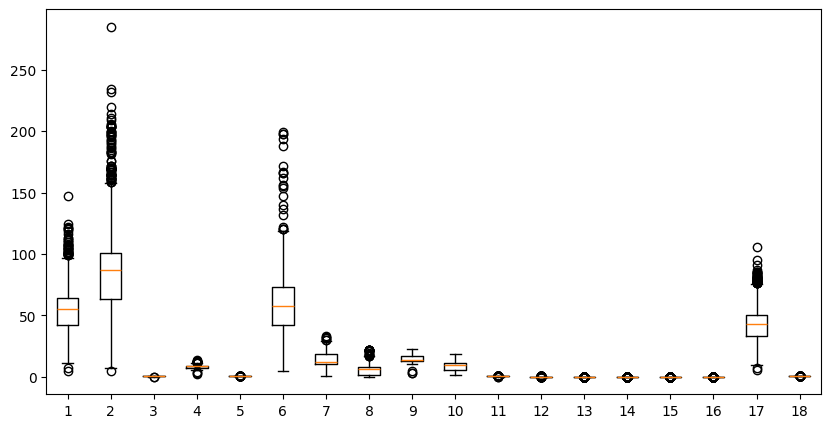

In [2]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(ocr_features)
plt.show()

We see it's not very standardized, we can normalize this to have a better estimation of the euclidiean distance.

In [3]:
#standardize the features
ocr_features = (ocr_features-ocr_features.mean(axis=0))/ocr_features.std(axis=0)

In [4]:
# Calculate eulidean distance in feature space
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

best_matches_indice = []
for i in range (len(ocr_features)):
    best_match = -1
    best_d = 1e10
    for j in range(len(ocr_features)):
        if i == j:
            continue
        dist = euclidean_distance(ocr_features[i], ocr_features[j])
        if dist< best_d:
            best_d = dist
            best_match = j
    best_matches_indice.append((i, ocr_class[i], best_match, ocr_class[best_match],best_d))

In [5]:
# or simplyfied code
best_matches_indice = []
for i in range (len(ocr_features)):
    distances = np.sqrt(((ocr_features[i] - ocr_features) ** 2).sum(axis=1))
    distances[i] = distances.max()  # Ignore self-distance
    best_match = np.argmin([euclidean_distance(ocr_features[i], ocr_features[j]) for j in range(len(ocr_features)) if i != j])
    best_matches_indice.append((i, ocr_class[i], best_match, ocr_class[best_match]))

In [6]:
# best_matches = np.array(best_matches)
# acc = (best_matches[:,1]==best_matches[:,3]).sum()/best_matches.shape[0]
# print(acc)

## Eigenfaces

The `faces.npy` file contains a 3D matrix containing 2963 images, each with 170x200 pixels, encoded in 8-bit grayscale.

In [7]:
from matplotlib import pyplot as plt

faces = np.load('../data/faces.npy')
print(faces.shape, faces.dtype, faces.min(), faces.max())

(2963, 200, 170) uint8 0 255


/tmp/ipykernel_15793/1482067089.py:3: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  faces = np.load('../data/faces.npy')


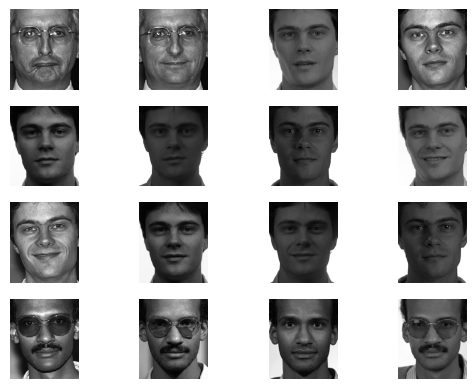

In [8]:
# Show some faces:
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(faces[i], cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

### Direct approach

1. Write a program that subsample the images (e.g. by 5), converts 2D images into lines, and collect all these lines into one single matrix **T**.
1. Zero-center **T** by removing the "mean image" ($T_i \leftarrow T_i - T_{mean}$)
1. Compute the variance/covariance matrix of **T**:
$$ \mathbf{S} = \mathbf{T^TT}$$
4. Compute the eigenvalues $\lambda_i$ and eigenvectors $\mathbf{v}_i$ of **S**
$$\mathbf{Sv}_i = \mathbf{T^T}\mathbf{Tv}_i = \lambda_i \mathbf{v}_i$$
5. The eigenvectors have the same size as the images, and are often referred to as "eigenfaces". Display some of them.

In [9]:
# Example of eigen value extraction
import numpy as np
from numpy import linalg as LA

print(np.diag((1,2,3)))
w,v = LA.eig(np.diag((1, 2, 3))) #w is eigenvalues, v is eigenvectors
print(w)
print(v)

[[1 0 0]
 [0 2 0]
 [0 0 3]]
[1. 2. 3.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


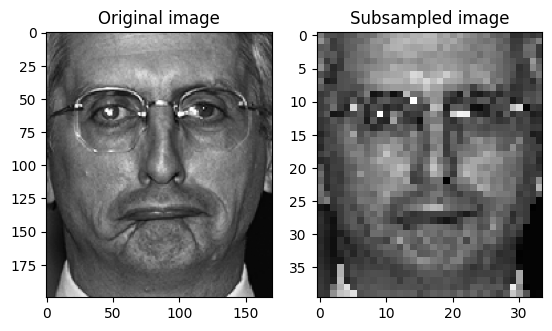

In [10]:
# Example of subsampling
im = faces[0]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.title("Original image")
plt.subplot(1,2,2)
plt.imshow(im[::5,::5], cmap=plt.cm.gray)
plt.title("Subsampled image")
plt.show()

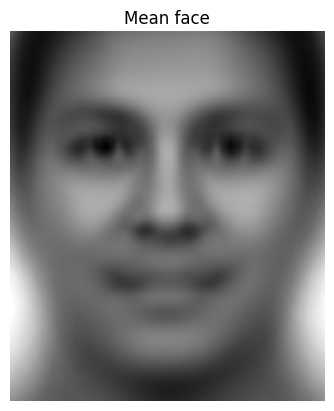

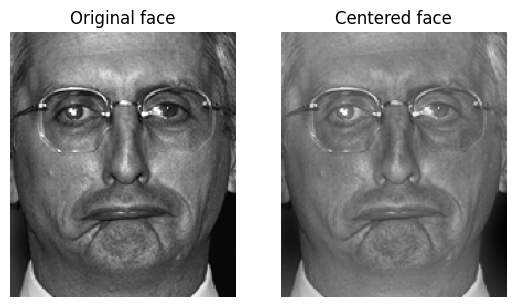

In [11]:
# fun, compute and show the mean face
def show_mean_face(faces):
    mean_face = np.mean(faces, axis=0)
    plt.imshow(mean_face, cmap=plt.cm.gray)
    plt.title("Mean face")
    plt.axis('off')
    plt.show()
    return mean_face
mean_face = show_mean_face(faces)

face = faces[0] - mean_face
plt.figure()
plt.subplot(1,2,1)
plt.imshow(faces[0], cmap=plt.cm.gray)
plt.title("Original face")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(face, cmap=plt.cm.gray)
plt.title("Centered face")
plt.axis('off')
plt.show()

In [12]:
# subsamples images
def subsample(im, factor):
    return im[::factor, ::factor]

# convert 2D images in 1D array (flatten) then add them together in the T matrix
faces_subsampled = np.array([subsample(im, 5) for im in faces])
print(faces_subsampled.shape)


(2963, 40, 34)


(2963, 1360)
(2963, 1360)
Shape of covariance matrix : (1360, 1360)
Shape of eigenvalues : (1360,) 
Shape of eigen vectors (1360, 1360)
109 0.9004433563654013
248 0.9502026266840313


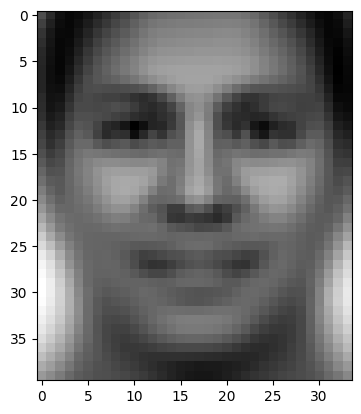

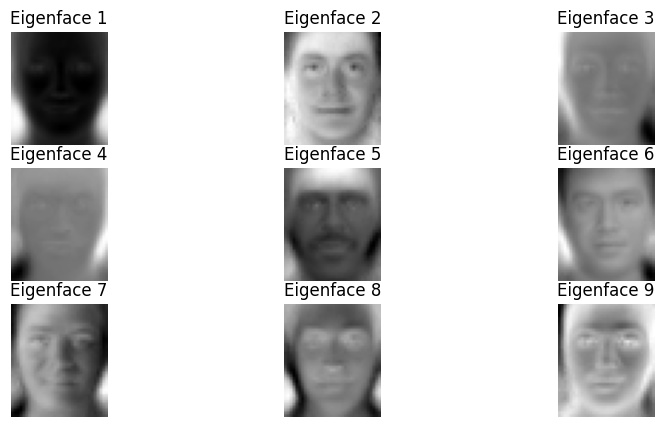

In [13]:
#flatten the images
def flatten(im):
    return im.flatten()

# construct the T matrix
T = np.array([flatten(im) for im in faces_subsampled])
print(T.shape)
# compute the mean face and ceter the faces
mean_face = np.mean(T, axis=0)
plt.imshow(mean_face.reshape(faces_subsampled[0].shape), cmap=plt.cm.gray)
T = T - mean_face
print(T.shape)
# compute the covariance matrix
S = np.cov(T.T)
print("Shape of covariance matrix :",S.shape)
# compute the eigenvalues and eigenvectors of the covariance matrix
w, v = LA.eig(S)
print("Shape of eigenvalues :" ,w.shape,"\nShape of eigen vectors", v.shape)
# show eigenfaces
plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(v[:, i].reshape(faces_subsampled[i].shape), cmap=plt.cm.gray) #take one column of the eigenvectors matrix (one eigenvector) and reshape it
    plt.title("Eigenface %d" % (i + 1))
    plt.axis('off')

explained_variance = w / np.sum(w)

for i in range(len(explained_variance)):
    if explained_variance[:i].sum() > 0.9: #how many dimensions are needed to explain 90% of the variance
        print(i, explained_variance[:i].sum())
        break
for i in range(len(explained_variance)):
    if explained_variance[:i].sum() > 0.95: #how many dimensions are needed to explain 95% of the variance
        print(i, explained_variance[:i].sum())
        break

### Compression

1. Reconstruct images using only the first N eigenfaces (e.g. N=100).
2. Compare (visually) reconstructed images with original images

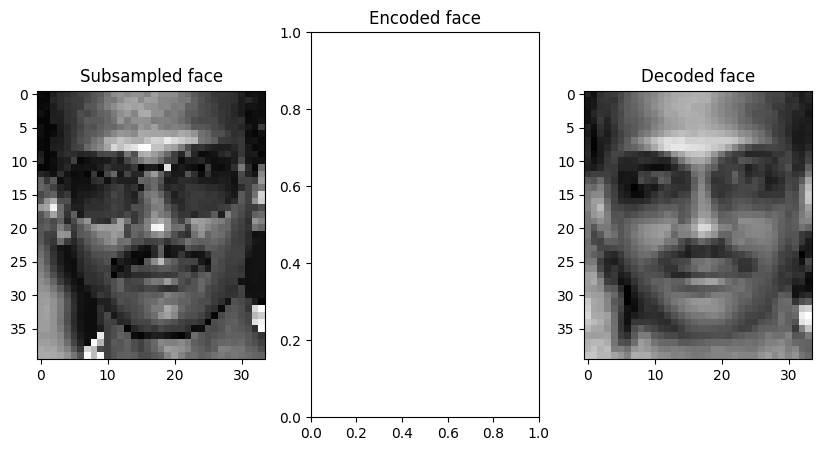

In [14]:
def encode(im,v,n): #this function gives the weights of the eigenfaces
    return np.dot(im,v)[:n]
def decode(encoded,v,n):
    return np.dot(encoded,(v.T)[:n])

face = T[12]
N = 109
encoded_face = encode(face, v, N)
decoded_face = decode(encoded_face, v, N)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow((face+mean_face).reshape(faces_subsampled[0].shape), cmap=plt.cm.gray) #add the mean face to have original image
plt.title("Subsampled face")
plt.subplot(1, 3, 2)
# plt.imshow(encoded_face.reshape(faces_subsampled[0].shape), cmap=plt.cm.gray)
plt.title("Encoded face")
plt.subplot(1, 3, 3)
plt.imshow((decoded_face+mean_face).reshape(faces_subsampled[0].shape), cmap=plt.cm.gray)
plt.title("Decoded face")
plt.show()


### Face recognition

1. Using the simplified vector space (e.g. 100 first eigenfaces), compute the euclidian distance between one face and the others.
2. For a subset of the image of the database, find the 4 closest matches.

In [15]:
N = 250
T_weights = np.array([encode(face,v,N) for face in T])
print("T weights shape : ",T_weights.shape)

T weights shape :  (2963, 250)


Distances shape :  (2963,)


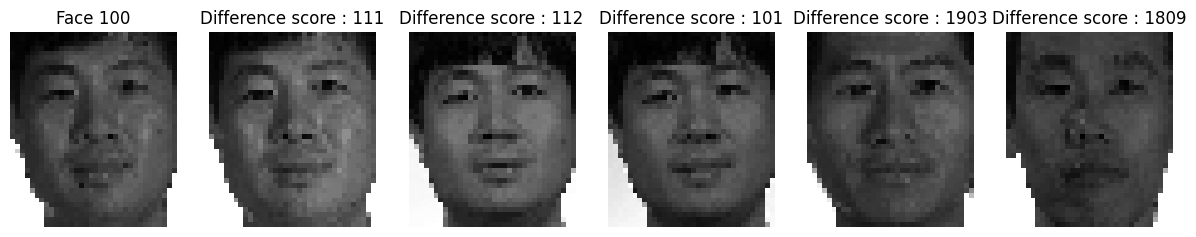

In [16]:
face_id = 100
# Give the distance of the face_id to all the other faces in the dataset
distances = np.sqrt(((T_weights[face_id] - T_weights) ** 2).sum(axis=1))
print("Distances shape : ",distances.shape)
distances[face_id]=distances.max() # Ignore self-distance
best_matches_indice = np.argsort(distances)[:5] # Get the 10 closest faces

plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow((T[face_id] + mean_face).reshape(faces_subsampled[0].shape), cmap=plt.cm.gray)
plt.title("Face %d" % (face_id))
plt.axis('off')
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow((T[best_matches_indice[i]] + mean_face).reshape(faces_subsampled[0].shape), cmap=plt.cm.gray)
    plt.title("Difference score : %d" % (best_matches_indice[i]))
    plt.axis('off')

### Indirect approach

Instead of using the eigenvalues/eigenvectors of $\mathbf{S} = \mathbf{T^TT}$, compute the the eigenvalues/eigenvectors of $\mathbf{Q} = \mathbf{TT^T}$.

Let $\mathbf{u_i}$ be the eigenvectors of $\mathbf{Q}$. We have:
$$\mathbf{TT^T}\mathbf{u}_i = \lambda_i \mathbf{u}_i$$

By multiplying to the left with $\mathbf{T^T}$, we have:
$$\mathbf{T^T}\mathbf{TT^T}\mathbf{u}_i = \lambda_i\mathbf{T^T}\mathbf{u}_i$$
$$\mathbf{S}\mathbf{T^T}\mathbf{u}_i = \lambda_i\mathbf{T^T}\mathbf{u}_i$$

Which means that if $\mathbf{u}_i$ is eigenvector of $\mathbf{Q}$, then $\mathbf{T^T}\mathbf{u}_i$ is eigenvector of $\mathbf{S}$.

The indirect approach thus becomes:
1. Compute the eigenvectors $\mathbf{u}_i$ of $\mathbf{Q} = \mathbf{TT^T}$.
1. Compute the eigenfaces with $\mathbf{v}_i = \mathbf{T^T}\mathbf{u}_i$ 
1. Reconstruct the images using only the first N eigenfaces (e.g. N=100)
1. Compare (visually) reconstructed images with original images
1. Use the indirect approach with more resolution (without subsampling the images)

Use this new feature space to perform the same face recognition method.

In [17]:

## -- Your code here -- ##
